# Import
Note: Import Order Matters

In [1]:
%matplotlib notebook
from src.solver.solver_ortools import solve as ortools_solve
from src.solver.solver_bab_dqn import solve
from src.problem.tsptw.environment.tsptw import TSPTW
from src.real_world import (
    generate_field_instance,
    to_real_coord,
    to_virtual_coord,
    calc_lat_lon,
    REAL_X_RANGE,
    REAL_Y_RANGE,
    to_real_time,
    to_virtual_time
)
import matplotlib
import folium
from folium.features import DivIcon
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# TSPTW問題の生成(in 文京区)

In [2]:
# Constant
DEPO = 0
RADIUS = 10

# Parameters
n_city = 20
grid_size = 100
solvable = False
time_window_size = 2 * 60  # 2時間
time_limit = 5
tw_ratio = 0.3

#Instance
instance = generate_field_instance(n_city, grid_size, solvable=solvable, max_tw_size=to_virtual_time(time_window_size), tw_ratio=tw_ratio)

### 描画関数

In [3]:
def display_solution(instance: TSPTW, solution: list):
    center = calc_lat_lon(np.mean(REAL_X_RANGE), np.mean(REAL_Y_RANGE))
    m = folium.Map(location=center, zoom_start=15)

    locations = list()
    for city in solution:
        x = instance.x_coord[city]
        y = instance.y_coord[city]
        window = instance.time_windows[city]
        r_x, r_y = to_real_coord(x, y)
        location = calc_lat_lon(r_x, r_y)
        locations.append(location)
        folium.CircleMarker(location=location, radius=RADIUS,
                            color='blue').add_to(m)
        window_start = int(round(to_real_time(window[0])))
        window_end = int(round(to_real_time(window[1])))
        text = "T:[" + str(window_start) + ", " + str(window_end) + "]"
        folium.map.Marker(
            location,
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html='<div style="font-size: 10pt; color: RED">%s</div>' % text,
                )
            ).add_to(m)
    folium.PolyLine(locations=locations).add_to(m)
    display(m)

### 解の評価指標生成関数

In [4]:
def solution_indicator(instance: TSPTW, solution: list):
    # 評価指標
    wait = 0
    delay = 0
    cur_time = 0
        
    pre_x, pre_y = instance.x_coord[solution[0]], instance.y_coord[solution[0]]
    for city in solution:
        x = instance.x_coord[city]
        y = instance.y_coord[city]
        window = instance.time_windows[city]  # [t_start, t_end]
        distance = ((x - pre_x) ** 2 + (y - pre_y) ** 2) ** 0.5
        tmp_time = cur_time + distance
        if tmp_time < window[0]:
            wait += window[0] - tmp_time
            cur_time = window[0]
        elif tmp_time > window[1]:
            delay += tmp_time - window[1]
            cur_time = tmp_time
        else:
            cur_time = tmp_time
        pre_x, pre_y = x, y
    return cur_time, wait, delay

## ３次元可視化

In [5]:
def display_solution_3d(instance, solution):
    
    x, y, z = list(), list(), list()
    for index in solution:
        x.append(instance.x_coord[index])
        y.append(instance.y_coord[index])
        # z.append(np.mean(instance.time_windows[index]))
        z.append(instance.time_windows[index][0])

    # Figureを追加
    fig = plt.figure(figsize = (8, 8))

    # 3DAxesを追加
    ax = fig.add_subplot(111, projection='3d')

    # Axesのタイトルを設定
    ax.set_title("Solution 3D Plot", size = 20)

    # 軸ラベルを設定
    ax.set_xlabel("X", size = 14)
    ax.set_ylabel("Y", size = 14)
    ax.set_zlabel("Mean Time WIndow", size = 14)

    # 曲線を描画
    ax.plot(x, y, z, color = "red")

    plt.show()

# 強化学習で求解

In [6]:
solution = solve(instance, time_limit)
print(solution)
if len(solution) > 0:
    time, wait, delay = solution_indicator(instance, solution)
    time, wait, delay = map(to_real_time, [time, wait, delay])
    time, wait, delay = map(round, [time, wait, delay])
    time, wait, delay = map(int, [time, wait, delay])

    print(f"配送時間：{time}分　待機時間：{wait}分　遅延時間：{delay}分")
    display_solution(instance, solution)
else:
    print("実行可能な配送経路を見つけられません")

[0, 1, 6, 4, 2, 17, 18, 13, 11, 9, 5, 10, 16, 7, 15, 3, 19, 8, 14, 12, 0]
配送時間：401分　待機時間：211分　遅延時間：0分


<IPython.core.display.Javascript object>


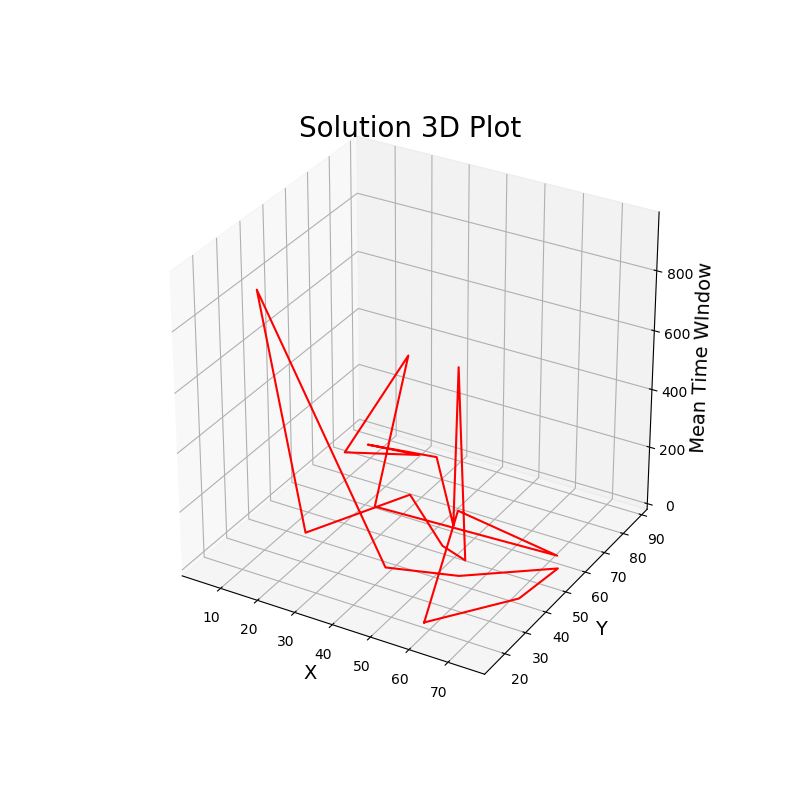

In [7]:
display_solution_3d(instance, solution)

# Google OR-Toolsで求解

In [8]:
or_solution = ortools_solve(instance)
if len(or_solution) > 2:
    time, wait, delay = solution_indicator(instance, or_solution)
    time, wait, delay = map(to_real_time, [time, wait, delay])
    time, wait, delay = map(round, [time, wait, delay])
    time, wait, delay = map(int, [time, wait, delay])

    print(f"配送時間：{time}分　待機時間：{wait}分　遅延時間：{delay}分")
    display_solution(instance, or_solution)
else:
    print("実行可能な配送経路を見つけられません")

実行可能な配送経路を見つけられません


In [9]:
instance.time_windows

array([[   0.        , 1295.73016419],
       [   0.        ,  323.93254105],
       [ 323.93254105,  647.8650821 ],
       [ 971.79762314, 1295.73016419],
       [ 323.93254105,  647.8650821 ],
       [ 647.8650821 ,  971.79762314],
       [   0.        ,  323.93254105],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419],
       [   0.        , 1295.73016419]])

## TODO
- 時間制約を色で可視化(丸をグラデーションlike 白 to 黒)
- 端から端への考察（はしはしが何個あって、それぞれの理由を考察、近くに時間制約上都合の良いノードがないことを確認＆可視化）
- 3D可視化が空間的な一筆書きっぽいものであることの確認
- 工夫の余地はどこから生まれるのかを考察
- 時間指定割合のコントロール(3-5割で分析)
- 時間幅のコントロール（30m, 2h, 4h)で考察
- Story作り


## 今後の課題として
- 軒先時間判定
- ノード数の一般化検証

## その場の話
- アカデミックな主張の仕方の検討
- その他建設的なアドバイスをもらうために利用する！